We start importing the required libraries. 

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import dolfinx.fem as fem
import dolfinx.mesh as mesh
import dolfinx.io as io
import dolfinx.plot as plot
import ufl
import basix 

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType
import sys
from meshes import generate_mesh_with_crack, generate_cylinder, generate_hollow_cylinder_2D
from petsc_solvers import SNESSolver
from utils import ColorPrint

petsc_options_SNES = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-09,
    "snes_stol": 0.0,
    "snes_max_it": 50,
    "snes_monitor": "",
    # "snes_monitor_cancel": "",
}

petsc_options_SNESQN = {
    "snes_type": "qn",
    "snes_qn_type": "lbfgs", #lbfgs broyden, badbroyden
    "snes_qn_m": 100,
    "snes_qn_scale_type": "jacobian", #<diagonal,none,scalar,jacobian> 	
    "snes_qn_restart_type": "none", #<powell,periodic,none> 
    "pc_type": "cholesky", # cholesky >> hypre > gamg,sor ; asm, lu, gas - don't work
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 50,
    # "snes_monitor": "",
    "snes_monitor_cancel": "",
}
        
def interpolate_quadrature(ufl_expr, fem_func:fem.Function):
    q_dim = fem_func.function_space._ufl_element.degree()
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(cells)
    fem_func.x.array[:] = expr_eval.flatten()[:]
    # fem_func.x.scatter_forward()

# Defining the function to interpolate a function defined over quadrature elements
# def interpolate_quadrature(ufl_expr, q_dim, mesh):
#     basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
#     quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
#     map_c = mesh.topology.index_map(mesh.topology.dim)
#     num_cells = map_c.size_local + map_c.num_ghosts
#     cells = np.arange(0, num_cells, dtype=np.int32)

#     expr_expr = fem.Expression(ufl_expr, quadrature_points)
#     expr_eval = expr_expr.eval(cells)
#     return expr_eval

# Interpolate an expression on an element
def interpolate_quadrature_on_element(expr, function_space:fem.FunctionSpace, mesh, cell_number):
    assert function_space.family() == 'Quadrature'
    
    q_dim = function_space.degree()
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, _ = basix.make_quadrature(basix_celltype, q_dim)

    expr_expr = fem.Expression(expr, quadrature_points)
    expr_eval = expr_expr.eval(cell_number)
    return expr_eval


In [2]:
R_i = 0.5
R_e = 1.
lc =.2
dist_min = .1
dist_max = .3
msh, cell_tags, facet_tags = generate_hollow_cylinder_2D(
        R_i=R_i,
        R_e=R_e,
        lc=0.05,  # caracteristic length of the mesh
        refinement_ratio=1,  # how much it is refined at the tip zone
        dist_min=dist_min,  # radius of tip zone
        dist_max=dist_max,  # radius of the transition zone
    )

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 50%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.0003911s, CPU 0.000378s)
Info    : Meshing 2D...
Info    : Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0365317s, CPU 0.03771s)
Info    : 1247 nodes 2496 elements
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 40%] Meshing curve 2 order 2
Info    : [ 70%] Meshing surface 2 order 2
Info    : Surface mesh: worst distortion = 0.936214 (0 elements in ]0, 0.2]); worst gamma = 0.736876
Info    : Done meshing order 2 (Wall 0.0075699s, CPU 0.007787s)


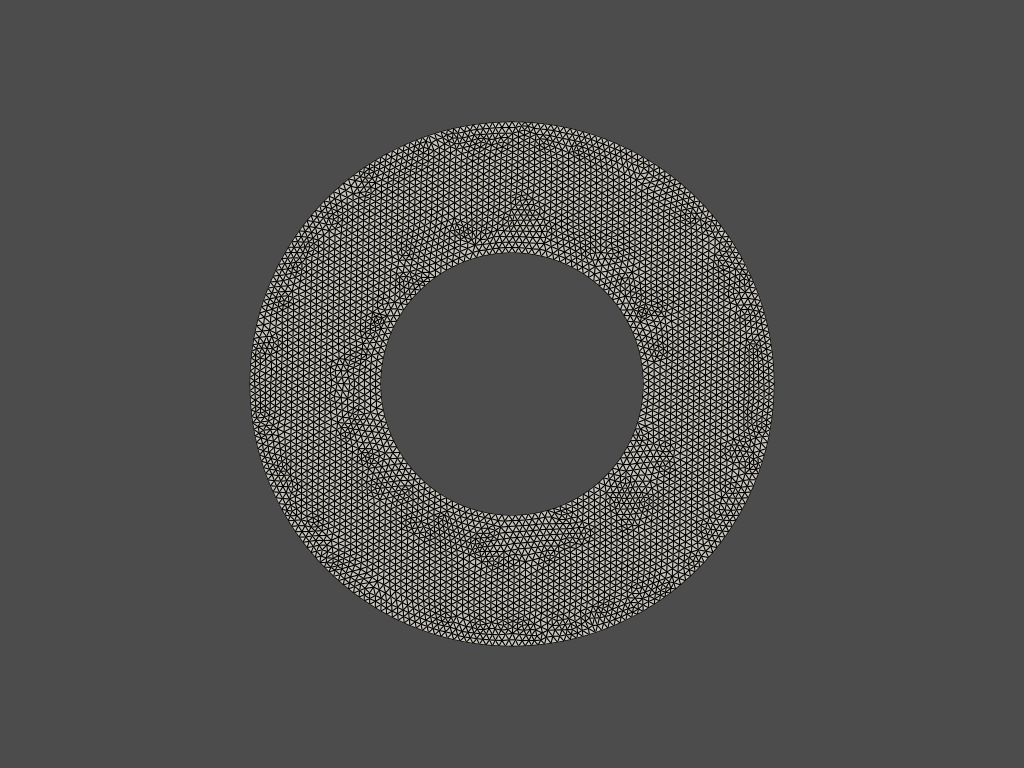

In [3]:
import pyvista
pyvista.start_xvfb()
pyvista.set_jupyter_backend("none")
grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(msh))
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.camera_position = 'xy'
pyvista.OFF_SCREEN = False
if not pyvista.OFF_SCREEN:
    plotter.show()

## Finite element function space

We use here linear Lagrange tetrahedral elements

In [4]:

deg_stress = 0
deg_u = 1

element = ufl.FiniteElement('Lagrange',msh.ufl_cell(),degree=deg_u)
V = fem.FunctionSpace(msh, element) # l'inconnue u est un scalaire, sinon on aurait écrit VectorFunctionSpace

element_stress = ufl.VectorElement("DG", msh.ufl_cell(), degree=deg_stress, quad_scheme='default')
element_stress_scalar = ufl.FiniteElement("DG", msh.ufl_cell(), degree=deg_stress, quad_scheme='default') 

V_stress = fem.FunctionSpace(msh, element_stress)
V_stress_scalar = fem.FunctionSpace(msh, element_stress_scalar)


In [5]:
inner_facets = facet_tags.find(1)
outer_facets = facet_tags.find(2)

inner_dofs = fem.locate_dofs_topological(V, msh.topology.dim-1, inner_facets)

outer_dofs = fem.locate_dofs_topological(V, msh.topology.dim-1, outer_facets)

u_t = fem.Constant(msh, 1.) # le vecteur u vaut u = u(r).e_z, on a donc qu'une composante scalaire : u. Il en va de même pour le chargement

bc_outer = fem.dirichletbc(np.array(0.,dtype=ScalarType), outer_dofs, V)
bc_inner = fem.dirichletbc(u_t, inner_dofs, V)
bcs = [bc_outer, bc_inner]

dx = ufl.Measure("dx",domain=msh,  metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"} )

ds = ufl.Measure("ds", domain=msh, subdomain_data=facet_tags)

n = ufl.FacetNormal(msh) # pour avoir le vecteur normal aux surfaces

$$
\mathcal{E}(u,d\varepsilon_p)=\int_\Omega \frac{\mu}{2} (\nabla u-\varepsilon_{p_{old}}-\Delta\varepsilon_p) \cdot (\nabla u-\varepsilon_{p_{old}}-\Delta\varepsilon_p)
+ \sigma_p (p_{old}+\Vert \Delta\varepsilon_p\Vert)
$$

$$
\sigma =  \mu (\nabla u-\varepsilon_{p_{old}}-\Delta\varepsilon_p),\quad \sigma_{elas}=\mu (\nabla u-\varepsilon_{p_{old}})
$$

Either 
$\Delta\varepsilon_p=0$ or the derivative with respect to $ \Delta\varepsilon_p$ gives
$$
\left(-\sigma_{elas}+\mu\, \Vert \Delta\varepsilon_p\Vert \frac{ \Delta\varepsilon_p}{\Vert \Delta\varepsilon_p\Vert}+\sigma_p \frac{ \Delta\varepsilon_p}{\Vert \Delta\varepsilon_p\Vert}\right)
\cdot
\hat{\Delta\varepsilon_p}=0
$$
For $\hat{\Delta\varepsilon_p}=\Delta\varepsilon_p$:
$$
\frac{\Delta\varepsilon_p}{\Vert \Delta\varepsilon_p\Vert}
=
\frac{\sigma_{elas}}{\Vert\sigma_{elas}\Vert}$$
$$
\Vert \Delta\varepsilon_p\Vert=\frac{\Vert\sigma_{elas}\Vert-\sigma_p}{\mu}
$$

$$
\Delta\varepsilon_p=
\frac{\Vert\sigma_{elas}\Vert-\sigma_p}{\mu}
\frac{\sigma_{elas}}{\Vert\sigma_{elas}\Vert}
$$

u est scalaire mais pas son gradent, on est donc obligé de travailler avec des contraintes et des déformations en tenseurs

In [6]:
sig00 = 1.
mu0 = 1.5
R0 = 0.2


mu = fem.Constant(msh,mu0) # PETSc.ScalarType(1.)

def eps(u):
    """Strain"""
    return ufl.grad(u)  

def L(v): 
    """The linear form of the weak formulation"""
    # Volume force
    b = fem.Constant(msh,ScalarType(0))

    # Surface force on the top 
    f = fem.Constant(msh,ScalarType(0.))
    return b * v * dx + f * v * ds(1)

def norm_s(sig):
    return ufl.sqrt(3*ufl.inner(sig, sig))

def sig_new(sigma_elas, sig_old, sig_0, p_old, R):  
    criterion = norm_s(sigma_elas)-sig_0-R*p_old
    direction = sigma_old/(norm_s(sigma_old))   ############# Different de CM : direction dépend de sig_old et pas sig_ela, est-ce qu'ils sont colinéaires ? A priori non car sigma_elas dépend de grad(u) qu'on ne connaît pas encore
    return ufl.conditional(criterion > 0., sigma_elas - 3*mu/(R+3*mu)*criterion*direction, sigma_elas)

def dp(sigma_elas, mu, sig_0, p_old, R):
    criterion = norm_s(sigma_elas)-sig_0-R*p_old
    return ufl.conditional(criterion > 0., criterion/(R+3.*mu), fem.Constant(msh,0.)) # PETSc.ScalarType(0.)

def deps_p(sigma_elas, sigma, mu):
    criterion = sigma_elas-sigma 
    test = norm_s(criterion)
    return ufl.conditional( test > 0., criterion/mu, ufl.as_vector([0.,0.]))

 
'''
+criterion/mu*direction and not minus (as analytics)  ########## CM had a minus
to avoid diverging forces
'''

'\n+criterion/mu*direction and not minus (as analytics)  ########## CM had a minus\nto avoid diverging forces\n'

In [7]:
u = fem.Function(V,name="u")
u_old = fem.Function(V)
v = ufl.TestFunction(V)

sig_0 = sig00
R = R0
eps_p = fem.Function(V_stress,name="epsp")
eps_p_old = fem.Function(V_stress)
p = fem.Function(V_stress_scalar,name="p")
p_old = fem.Function(V_stress_scalar)
sigma = fem.Function(V_stress,name="stress")
sigma_old = fem.Function(V_stress)

sigma_elas = sigma_old+mu*eps(u-u_old)
sigma_new = sig_new(sigma_elas, sigma_old, sig_0, p_old, R)

residual = ufl.inner(sigma_new, eps(v)) * dx - L(v)
my_problem = SNESSolver(residual, u, bcs=bcs, petsc_options=petsc_options_SNES)

stress_expr = fem.Expression(sigma_new, V_stress.element.interpolation_points())
stress_elas_expr = fem.Expression(sigma_elas, V_stress.element.interpolation_points())

p_expr = fem.Expression(p_old+dp(sigma_elas, mu, sig_0, p_old, R), V_stress_scalar.element.interpolation_points())
eps_p_expr = fem.Expression(eps_p_old+deps_p(sigma_elas, sigma_new, mu), V_stress.element.interpolation_points())





In [8]:
with io.XDMFFile(MPI.COMM_WORLD, "output/antiplane_V3_test.xdmf", "w") as file:
    file.write_mesh(msh) # u.function_space.mesh
t_max = 1.
loads = np.linspace(0,t_max,int(t_max*20))
plastic_dissipations = np.zeros_like(loads)
Fi = []
Fe = []

'''
u.x.set(0.)
eps_p.x.set(0.)
p.x.set(0.)
sigma.x.set(0.)
'''

for i,t in enumerate(loads):
    u_old.x.array[:] = u.x.array
    p_old.x.array[:] = p.x.array
    eps_p_old.x.array[:] = eps_p.x.array
    sigma_old.x.array[:] = sigma.x.array
    
    u_t.value = t
    
    ColorPrint.print_info(f"Solve for t={t:5.3f}")
    out = my_problem.solve()
    ColorPrint.print_info(out)
    
    # update 
    eps_p.interpolate(eps_p_expr)
    eps_p.x.scatter_forward()    
    p.interpolate(p_expr)
    p.x.scatter_forward()
    sigma.interpolate(stress_expr)
    sigma.x.scatter_forward()
    plastic_dissipations[i] = fem.assemble_scalar(fem.form(sig_0 * p * dx))
    
    # calcul des forces sur les bords
    inner_force = fem.assemble_scalar(fem.form(ufl.dot(sigma, n)*ds(1)))
    outer_force = fem.assemble_scalar(fem.form(ufl.dot(sigma, n)*ds(2)))
    Fi.append(inner_force)
    Fe.append(outer_force)
    
    with io.XDMFFile(MPI.COMM_WORLD, "output/antiplane_V3_test.xdmf", "a") as file:
        #file.write_mesh(u.function_space.mesh)
        file.write_function(u,t)
        file.write_function(eps_p,t)
        file.write_function(p,t)
        file.write_function(sigma,t)
t_final = t

Solve for t=0.000
  0 SNES Function norm 0.000000000000e+00 
(0, 2)
Solve for t=0.053
  0 SNES Function norm 8.753111358914e-01 
  1 SNES Function norm 7.015292022563e-16 
(1, 2)
Solve for t=0.105
  0 SNES Function norm 8.753111358914e-01 
  1 SNES Function norm 9.251653737393e-16 
(1, 2)
Solve for t=0.158
  0 SNES Function norm 8.753111358914e-01 
  1 SNES Function norm 2.165914824541e-02 
  2 SNES Function norm 1.302772033379e-01 
  3 SNES Function norm 1.982152883493e-03 
  4 SNES Function norm 1.723604720795e-04 
  5 SNES Function norm 5.122682828601e-08 
  6 SNES Function norm 5.905415565375e-15 
(6, 2)
Solve for t=0.211
  0 SNES Function norm 4.782655408576e-01 
  1 SNES Function norm 4.959096487955e-02 
  2 SNES Function norm 1.679153558497e-01 
  3 SNES Function norm 4.451920019530e-03 
  4 SNES Function norm 4.233192702154e-04 
  5 SNES Function norm 2.826987620198e-07 
  6 SNES Function norm 1.592618201969e-13 
(6, 2)
Solve for t=0.263
  0 SNES Function norm 5.096833452855e-0

[0.0, 0.6833003199413672, 1.366600639882734, 1.877575328949065, 2.024201902038501, 2.1295565960751515, 2.2135015371127817, 2.286641395477427, 2.3524301093564244, 2.413287140194386, 2.4697730048069158, 2.5231576441265395, 2.5739914383758897, 2.6224240902512097, 2.6690261590267603, 2.713940951827389, 2.7572573756278658, 2.7992240934172568, 2.840121128990719, 2.87979687303181]


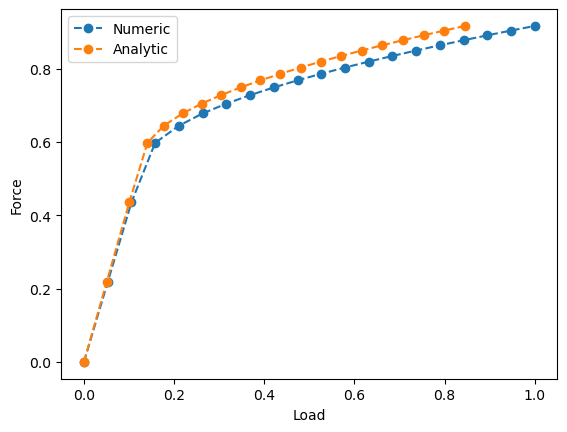

In [9]:
print(Fi)
Fi_an = np.array(Fi)/(2*np.pi*R_i)
t_Fi = np.zeros(len(Fi_an))


for i, f_in in enumerate(Fi_an) :
    if f_in < sig00/np.sqrt(3):
        t_fin = -f_in/mu0*R_i*np.log(R_i/R_e)
    else :
        t_fin = -f_in*R_i/mu0*np.log(R_i/R_e)+3*f_in*R_i/R0*(np.log(np.sqrt(3)*f_in/sig00)-1)+sig00*np.sqrt(3)/R0*R_i
    t_Fi[i] = t_fin
plt.plot(loads, Fi_an, "o--", label = 'Numeric')
plt.plot(t_Fi, Fi_an, "o--", label = 'Analytic')
plt.legend()
plt.xlabel('Load')
plt.ylabel('Force')
plt.show()

In [10]:
Fi_an[-1]

0.9166678148871918

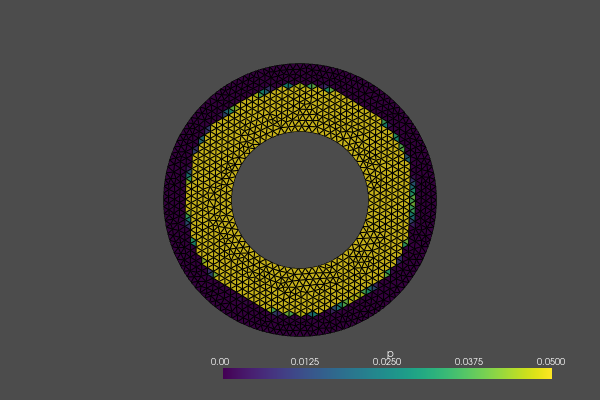

In [11]:
import pyvista
pyvista.start_xvfb()

# Create plotter and pyvista grid
topology, cell_types, geometry = plot.create_vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid.cell_data["p"] = p.x.array.real
u_grid.set_active_scalars("p")
u_plotter = pyvista.Plotter(window_size=(600, 400))
u_plotter.add_mesh(u_grid, show_edges=True,clim=[0,0.05])
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()


# Etude des profils sur l'épaisseur du cylindre

In [12]:
import numpy as np
import extract
import scipy.optimize as op

n_points = 30
tol=1e-3
list_r = np.linspace(R_i+tol,R_e-tol, n_points)
list_u = np.zeros(n_points)
list_p = np.zeros(n_points)
list_eps_p_yy = np.zeros(n_points)
list_sigma_yy = np.zeros(n_points)

for i,r in enumerate(list_r):
    list_u[i] = extract.solution(msh, u, 0, r)[0]
    list_p[i] = extract.solution(msh, p, 0, r)[0]
    list_eps_p_yy[i] = extract.solution(msh, eps_p, 0, r)[1]
    list_sigma_yy[i] = extract.solution(msh, sigma, 0, r)[1]
    
list_u_analytic = np.zeros(n_points)
list_p_analytic = np.zeros(n_points)
list_eps_p_analytic = np.zeros(n_points)
list_sigma_analytic = np.zeros(n_points)


equa = lambda f : -f*R_i/mu0*np.log(R_i/R_e)+3*f*R_i/R0*(np.log(np.sqrt(3)*f/sig00)-1)+sig00*np.sqrt(3)/R0*R_i-t_max
f0 = op.fsolve(equa,0.6) # on veut annuler equa en variant f, on initialise à f=0.6
#f0 = Fi_an[-1] # pour vérifier que la valeur est cohérente : ok
r_bar = R_i*np.sqrt(3)*f0/sig00
print("Position du front de plastification : {}".format(r_bar))
      
lnRR = np.log(R_i/R_e)


for i,r in enumerate(list_r):
    sig_eq = f0*R_i/r
    if r>r_bar : # zone élastique
        list_u_analytic[i] = -R_i*f0/mu0*np.log(r/R_e)
        list_p_analytic[i] = 0.
        list_eps_p_analytic[i] = 0.
        list_sigma_analytic[i] = -sig_eq
    else : # zone plastique
        list_u_analytic[i] = -f0*R_i*(R0+3*mu0)/(mu0*R0)*np.log(r/R_e)+3*f0*R_i/R0*(np.log(np.sqrt(3)*f0/sig00)+lnRR-1)+sig00*np.sqrt(3)/R0*r
        list_p_analytic[i] = 1/R0*(np.sqrt(3)*sig_eq-sig00)
        list_eps_p_analytic[i] = -np.sqrt(3)* 1/R0*(np.sqrt(3)*sig_eq-sig00)
        list_sigma_analytic[i] = -sig_eq
      

Position du front de plastification : [0.82858788]


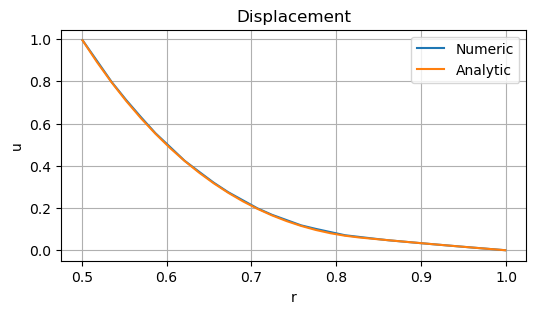

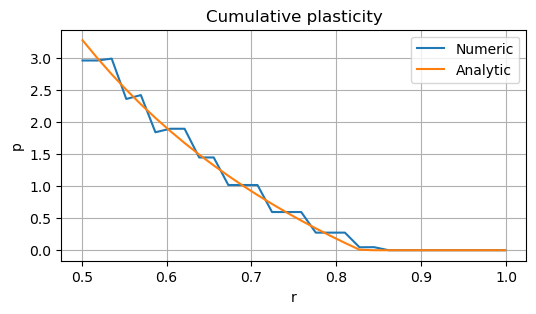

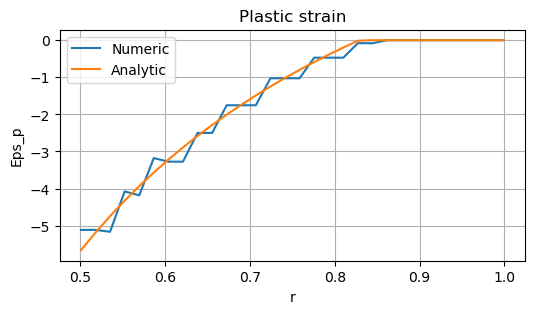

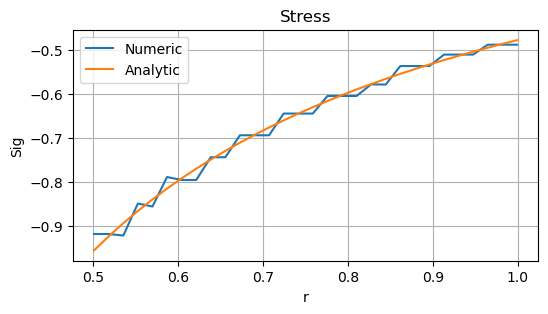

In [14]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(6, 3))
plt.plot(list_r, list_u, label = 'Numeric')
plt.plot(list_r, list_u_analytic, label = 'Analytic')
plt.xlabel('r')
plt.ylabel('u')
plt.title('Displacement')
plt.legend()
plt.grid()
plt.show()
fig.tight_layout()
fig.savefig('comp_u')

fig=plt.figure(figsize=(6, 3))
plt.plot(list_r, list_p, label = 'Numeric')
plt.plot(list_r, list_p_analytic, label = 'Analytic')
plt.xlabel('r')
plt.ylabel('p')
plt.title('Cumulative plasticity')
plt.legend()
plt.grid()
plt.show()
fig.tight_layout()
fig.savefig('comp_p')

fig=plt.figure(figsize=(6, 3))
plt.plot(list_r, list_eps_p_yy, label = 'Numeric')
plt.plot(list_r, list_eps_p_analytic, label = 'Analytic')
plt.xlabel('r')
plt.ylabel('Eps_p')
plt.title('Plastic strain')
plt.legend()
plt.grid()
plt.show()
fig.tight_layout()
fig.savefig('comp_epsp')

fig=plt.figure(figsize=(6, 3))
plt.plot(list_r, list_sigma_yy, label = 'Numeric')
plt.plot(list_r, list_sigma_analytic, label = 'Analytic')
plt.xlabel('r')
plt.ylabel('Sig')
plt.title('Stress')
plt.legend()
plt.grid()
plt.show()
fig.tight_layout()
fig.savefig('comp_sig')
